# Toy Model

Trying toy model inspired by [Griffiths & Steyvers, 2004](https://doi.org/10.1073/pnas.0307752101).

In [1]:
from collections.abc import Sequence
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from timeit import timeit

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
## One hot for numpy
def np_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

### **Sampling Behaviour of `tfp.Distributions`**

In [3]:
## tfd.Categorical sampling behaviour:
probs = tf.constant([[0., 0., 1.], 
                     [1., 0., 0.]])
print(probs.shape)
tfd.Categorical(probs=probs).sample(4).numpy()

(2, 3)


array([[2, 0],
       [2, 0],
       [2, 0],
       [2, 0]])

In [4]:
## tfd.Dirichlet sampling behaviour:
conc = tf.constant([[0.1, 0.1, 0.1], 
                    [  2.,  2.,  2.]])
tfd.Dirichlet(conc).sample().numpy()

array([[0.02140409, 0.01427036, 0.9643255 ],
       [0.38862276, 0.16176145, 0.44961584]], dtype=float32)

$\rightarrow$ Samples come in by row. For Categorical the sample size is flexible. For Dirichlet the sample cise is bounded to the concentrations.

## **Setting up Topics and Data**

### Understand The indices in this Notebook

- $K$ is the number of topics 
- $D$ is the number of documents
- $I_d$ is the number of words in document $d$
- $N_{\mathrm{max}}$ is the maximum number of words per doument, i. e. $N_{\mathrm{max}} = \max_d \{I_d\}$
- $T$ is the total number of words, i. e. $T = \sum_d I_d$
- $V$ is the vocabulary size which should be a square of an integer for the visualization purposes of this notebook

### **1. Specify global parameters**

In [5]:
## Constructing iterator for single documents N's
class sliceConverter(Sequence):
    def __init__(self, N_D: tf.Tensor):
        assert N_D.ndim == 1
        N_idx = tf.cumsum(N_D)
        N_idx = tf.repeat(N_idx, 2)
        self.N_idx   = tf.concat([[0], N_idx], axis=0).numpy()
        self.N_max   = tf.reduce_mean(N_D).numpy()
        self.N_total = N_idx[-1].numpy()
        self.single_lengths = N_D

    def __len__(self):
        return int((self.N_idx.shape[0] - 1) / 2)

    def __getitem__(self, k):
        # if type(k) == int:
        #     if k >= 0:
        #         return tf.range(self.N_idx[2*k], self.N_idx[2*k + 1])
        #     if k < 0:
        #         i = len(self) + k
        #         return tf.range(self.N_idx[2*i], self.N_idx[2*i + 1])
        # elif type(k) == slice:
        #     start, stop, step = k.indices(len(self))
        #     return [self[i] for i in range(start, stop, step)]
        if type(k) == int:
            if k >= 0:
                return slice(self.N_idx[2*k], self.N_idx[2*k + 1], 1)
            if k < 0:
                i = len(self) + k
                return slice(self.N_idx[2*i], self.N_idx[2*i + 1], 1)
        elif type(k) == slice:
            start, stop, step = k.indices(len(self))
            return [self[i] for i in range(start, stop, step)]
        else:
            raise TypeError("Index must be integer or slice.")

    def __iter__(self):
        self.idx = 0
        self.maxiter = len(self)
        return self

    def __next__(self):
        if self.idx < self.maxiter:
            ret = self.__getitem__(self.idx)
            self.idx += 1
            return ret
        else:
            raise StopIteration

In [6]:
K       = 10    # Number of Topics
sqrtV   = 5     # Square Root of the Number of "Vocabulary" (must be sqrt such that pictorial interpretation is possible)
D       = 1000  # Number of documents
N_rate  = None   # Number of words per document (either as rate for Poisson Distribution
N_fixed = 100  #   or as fixed value)

V = int(sqrtV**2)

### **2. Generating Data**

In [7]:
def generate_LDA(D: int, K: int, sqrtV: int, N_fixed: int=None, N_rate: int=None) -> tuple():
    """
    Generates LDA-Data from the LDA generative Process. 
    Thetas get constructed as rows and columns of a quadratic sqrtV-grid.
    Either N_fixed ot N_rate has to be passed
    """
    assert (N_fixed is None) != (N_rate is None), "Exactly one of N_fixed and N_rate must be passed."


    ## Number of words per document
    if N_rate is not None:
        N_D_dist = tfd.Poisson(rate=100)
        N_D      = tf.cast(N_D_dist.sample(D), dtype=tf.int32)
    if N_fixed is not None:
        N_D = np.array(D*[N_fixed])
    N_idx    = sliceConverter(N_D)
    

    ## Word grid
    V = int(sqrtV**2)
    V_grid = np.reshape(np.arange(0, V), newshape=(sqrtV, sqrtV))


    ## Topic-Word Distribution
    #  Words belonging to a topic are rows and columns
    Theta_idx = [row for row in V_grid] + [col for col in V_grid.T]
    Theta = np.zeros((K, V))
    for k, idx in enumerate(Theta_idx):
        Theta[k, idx] = 1. / sqrtV
    Theta = tf.constant(Theta, dtype=tf.float32)


    ## Document-Topic Distribution
    #  Initializing Alpha manually to 1.
    Alpha = 1
    dist_Pi = tfd.Dirichlet(K*[Alpha])
    Pi      = dist_Pi.sample(D)


    ## Topic Assignments of word c_{dik} of word w_{di}
    dist_C  = tfd.Categorical(probs=Pi)
    C_NmaxD = dist_C.sample(tf.reduce_max(N_D))

    C_T = []
    for d in range(D):
        C_T_col = C_NmaxD[:N_D[d], d]
        C_T.append(C_T_col)
    C_T = tf.concat(C_T, axis=0)
    C_TK = tf.one_hot(C_T, depth=K, axis=-1)


    ## Draw words w_{di}
    dist_W_T = tfd.Categorical(probs=tf.gather(Theta, C_T))
    W_T      = dist_W_T.sample()


    return Theta, Pi, C_T, C_TK, W_T, N_idx

In [8]:
Theta, Pi, C_T, C_TK, W_T, N_idx = generate_LDA(D, K, sqrtV, N_fixed=N_fixed, N_rate=N_rate)

In [9]:
## To extract topic-word assignments and document-words for a 
#  specific document, use the slice converter:
doc_slice = N_idx[11]

print("Topics for the Words in Document d=11:")
print(C_T[doc_slice])
print("\nWords in Document d=11:")
print(W_T[doc_slice])

Topics for the Words in Document d=11:
tf.Tensor(
[1 6 1 5 8 8 8 6 4 1 6 4 5 3 6 5 9 6 4 5 2 3 5 5 1 5 9 4 5 4 8 6 1 4 9 8 3
 5 5 8 3 5 8 5 6 5 3 9 1 9 4 6 6 8 9 5 4 6 4 3 5 9 6 7 9 8 5 2 4 4 7 9 9 4
 5 7 6 5 5 8 3 9 4 5 8 6 8 3 5 4 5 7 9 3 5 6 5 6 3 4], shape=(100,), dtype=int32)

Words in Document d=11:
tf.Tensor(
[ 5 11  5 15  3 18 23  1 23  7  6 23 10 19  1  5  4 21 20  5 12 19  0 15
  7  5  9 23  5 24 18 11  9 20 19 18 18 15 15 23 17  5 13 20 11 15 18  4
  5  9 24 21  1  3 24 15 20  1 24 17 10  4 16  7 19 23 15 12 24 23  7 19
  4 23 20  7 21  0 10 18 19 14 21 20  8 21  3 15 10 20 15 17  9 16 10 21
 15 21 16 22], shape=(100,), dtype=int32)


### **3. Checking Shapes**

In [10]:
## For development purposes:
def print_all_shapes():
    print("Π-Shape (D docs x K topics)")
    print(Pi.shape)
    print("\nΘ-Shape (K topic x V vocab)")
    print(Theta.shape)
    print("\nC_T-Shape (Topic for each word T=sum_d I_d)")
    print(C_T.shape)
    print("\nC_TK-Shape (one-hot for each topic k in {1, K})")
    print(C_TK.shape)
    print("\nW-Shape (sum_d I_d words)")
    print(W_T.shape)

In [11]:
print_all_shapes()

Π-Shape (D docs x K topics)
(1000, 10)

Θ-Shape (K topic x V vocab)
(10, 25)

C_T-Shape (Topic for each word T=sum_d I_d)
(100000,)

C_TK-Shape (one-hot for each topic k in {1, K})
(100000, 10)

W-Shape (sum_d I_d words)
(100000,)


## **Visualization**

In [12]:
def format_to_img(arr, sqrtV=sqrtV):
    vals = dict(zip(*np.unique(arr, return_counts=True)))
    img = []

    for i in range(int(sqrtV**2)):
        if i in vals:
            img.append(vals[i])
        else:
            img.append(0)

    img = np.array(img).reshape(sqrtV, sqrtV)

    return img

In [13]:
Pi[10,:]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.38780424, 0.18907806, 0.02911452, 0.06413591, 0.19551848,
       0.0772825 , 0.03335454, 0.00486895, 0.01072818, 0.00811451],
      dtype=float32)>

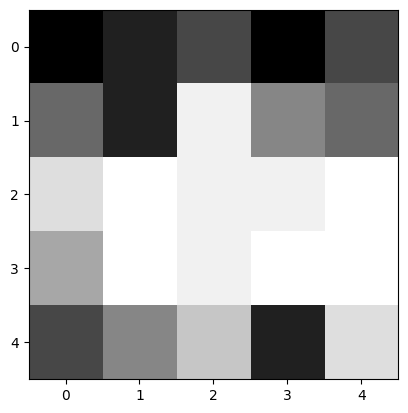

In [14]:
plt.imshow(format_to_img(W_T[N_idx[10]]), cmap="Greys")

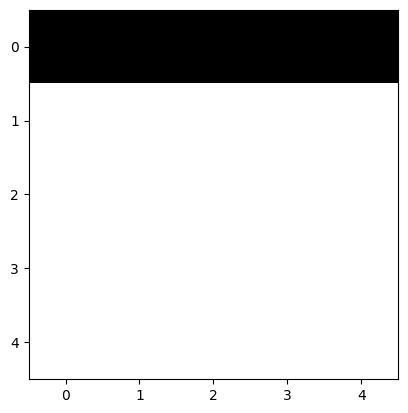

In [15]:
plt.imshow(tf.reshape(Theta[0,:], (sqrtV, sqrtV)), cmap="Greys")

## **Gibbs Sampler**

### **N-Tensor**
One efficiency crtitical step is to vectorize 
$$
    n_{dkv} =  \{i \, \vert \, w_{di} == v \ \& \ c_{idk} ==1\}
$$
as much as possible. Due to the fact, that the document lengths are variable there is the choice between looping over the number of documents or padding the documents to a unique length. The padding does not need a word-token, it can be done by padding the $C$ matrix with $0$, therefore it will not affect $N$. Then the counting can be realized by stacking $W$ $K$ times along the last axis to match the shape of $C$.

#### 1. Multiloop over all Dimensions

Mainly for test purposes. Horribly slow.

In [16]:
def multiloop_N_tensor(W_T, C_TK, N_idx, D=D, V=V):
    K    = C_TK.shape[1]
    W_T  = W_T.numpy()
    C_TK = C_TK.numpy()
    N_DKV = np.zeros(shape=(D, K, V))
    
    for d in tqdm(range(D)):
        di = N_idx[d]
        for k in range(K):
            for v in range(V):
                for w_di, c_dik in zip(W_T[di], C_TK[di, k]):
                    if w_di == v and c_dik == 1:
                        N_DKV[d, k, v] += 1

    return N_DKV

##### Test and Benchmark

In [17]:
# N_test1 = multiloop_N_tensor(W_T, C_TK, N_idx)

In [18]:
# %timeit multiloop_N_tensor(W_T, C_TK, N_idx)

#### 2. Single-Loop over $D$ with numpy

In [19]:
def singleloop_N_tensor(W_T, C_TK, N_idx, D=D, V=V, verbose=False):
    K = C_TK.shape[1]
    W_T   = W_T.numpy()
    C_TK  = C_TK.numpy()
    N_DKV = np.zeros(shape=(D, K, V))

    ## Preparing W-stacking by shifting all entries one "up" s. t. v is counted 
    #  from 1 to V+1 instead from 0 to V. This enables to collapse the "&" in the
    #  set to be collapsed to a matrix product
    Wp1 = W_T + 1
    
    if verbose:
        iter = tqdm(range(D))  
    if not verbose:
        iter = range(D)

    for d in iter:
        di = N_idx[d]
        W_ = Wp1[di]
        C_TK_ = C_TK[di]

        Nd = len(W_)

        ## Stacking W
        W_stacked = np.stack(K*[W_], axis=-1)

        ## Elementwise product combines logical & in conditio
        #  Choosing int32 as product dtype for efficiency.
        C_Dot_W = np.multiply(W_stacked, C_TK_)

        ## The v-dimension of N is a one-hot encoding for the vocabulary:
        N_dNdKVp1 = np_one_hot(C_Dot_W.astype(np.int32), V+1)

        ## Reverting the v-shift by dropping the 0 one-hot dimension
        N_dNdKV = N_dNdKVp1[:, :, 1:]

        ## Summing along v-dimension
        assert N_dNdKV.shape[0] == Nd
        N_dKV = np.sum(N_dNdKV, axis=0)

        ## Append to full tensor
        N_DKV[d, :, :] = N_dKV

    return N_DKV

##### Test and Benchmark

In [20]:
N_test2 = singleloop_N_tensor(W_T, C_TK, N_idx)

In [21]:
# %timeit singleloop_N_tensor(W, C_TK, N_idx)

In [22]:
print(f"Numpy implementation which avoides all loops but the loop over documents is about a factor {round(8150./129., 1)} more efficient as multiloop version.")

Numpy implementation which avoides all loops but the loop over documents is about a factor 63.2 more efficient as multiloop version.


#### 3. Vectorized with Padding using `tf`

In [23]:
## Padding Functions
def fungen_pad_CW(N_idx):
    
    @tf.function
    def padd_CW(W_T, C_TK):
        K = C_TK.shape[1]

        ## Reshaping C_TK to C_DNmaxK and
        #            W_T  to W_DNmax
        C_DNmaxK_list = []
        W_DNmax_list  = []
        N_max = tf.reduce_max(N_idx.single_lengths)

        for di in N_idx:
            CdiK = C_TK[di, :]
            Wdi  = W_T[di]
            Nd   = CdiK.shape[0]

            N_pad = N_max - Nd

            ## C
            pad = tf.zeros(shape=(N_pad, K), dtype=CdiK.dtype)
            CdiK_pad = tf.concat([CdiK, pad], axis=0)
            C_DNmaxK_list.append(CdiK_pad)

            ## W
            pad = tf.zeros(shape=(N_pad), dtype=Wdi.dtype)
            Wdi_pad = tf.concat([Wdi, pad], axis=0)
            W_DNmax_list.append(Wdi_pad)

        C_DNmaxK = tf.stack(C_DNmaxK_list, axis=0)
        W_DNmax  = tf.stack(W_DNmax_list, axis=0)

        return W_DNmax, C_DNmaxK

    return padd_CW

## Using a tf.function decorator causes the creation to take pretty long because a graph
#  is built which has to take the document lengths into account. This might be only 
#  useful if the function itself takes long to run without a tf.function... Maybe
#  Better use just the plain-non tf.function-converted:

def padd_CW(W_T, C_TK, N_idx):
    K = C_TK.shape[1]

    ## Reshaping C_TK to C_DNmaxK and
    #            W_T  to W_DNmax
    C_DNmaxK_list = []
    W_DNmax_list  = []
    N_max = tf.reduce_max(N_idx.single_lengths)

    for di in N_idx:
        CdiK = C_TK[di, :]
        Wdi  = W_T[di]
        Nd   = CdiK.shape[0]

        N_pad = N_max - Nd

        ## C
        pad = tf.zeros(shape=(N_pad, K), dtype=CdiK.dtype)
        CdiK_pad = tf.concat([CdiK, pad], axis=0)
        C_DNmaxK_list.append(CdiK_pad)

        ## W
        pad = tf.zeros(shape=(N_pad), dtype=Wdi.dtype)
        Wdi_pad = tf.concat([Wdi, pad], axis=0)
        W_DNmax_list.append(Wdi_pad)

    C_DNmaxK = tf.stack(C_DNmaxK_list, axis=0)
    W_DNmax  = tf.stack(W_DNmax_list, axis=0)

    return W_DNmax, C_DNmaxK

In [24]:
## Actual n-Tensor
@tf.function
def tf_N_tensor(W_DNmax, C_DNmaxK, V=V):

    ## Extracting shapes
    D = C_DNmaxK.shape[0]
    N = C_DNmaxK.shape[1]
    K = C_DNmaxK.shape[2]
    
    ## Preparing W-stacking by shifting all entries one "up" s. t. v is counted 
    #  from 1 to V+1 instead from 0 to V. This enables to collapse the "&" in the
    #  set to be collapsed to a matrix product
    Wp1 = W_DNmax + 1
    W_stacked = tf.stack(K*[Wp1], axis=-1)    

    ## Elementwise product combines logical & in condition.
    #  Choosing int32 as product dtype for efficiency.
    C_DNmaxK_int = tf.cast(C_DNmaxK, dtype=tf.int32)
    C_Dot_W = tf.math.multiply(W_stacked, C_DNmaxK_int)

    ## The v-dimension of N is a one-hot encoding for the vocabulary:
    N_DNKVp1 = tf.one_hot(C_Dot_W, V+1, dtype=tf.int32)

    ## Reverting the v-shift by dropping the 0 one-hot dimension
    N_DNKV = N_DNKVp1[:, :, :, 1:]

    ## Summing along v-dimension
    assert N_DNKV.shape[1] == N
    N_DKV = tf.reduce_sum(N_DNKV, axis=1)

    ## Turn to float for gibbs sampler
    N_DKV = tf.cast(N_DKV, dtype=tf.float32)

    return N_DKV

##### Test and Benchmark

Padding

In [25]:
# %timeit tf_padd_CW(W, C_TK)

In [26]:
# %timeit padd_CW(W, C_TK, N_idx)

In [27]:
print(f"With a tf.function the padding is about a factor {round(970./63., 1)} more efficient, when the graph is already constructed. Yet constructing the graph takes a while.")

With a tf.function the padding is about a factor 15.4 more efficient, when the graph is already constructed. Yet constructing the graph takes a while.


In [28]:
W_DNmax, C_DNmaxK = padd_CW(W_T, C_TK, N_idx)
# tf_padd_CW = fungen_pad_CW(N_idx)
# W_DNmax, C_DNmaxK = tf_padd_CW(W_T, C_TK)

N-Tensor itself

In [29]:
# %timeit tf_N_tensor(W_DNmax, C_DNmaxK)

In [30]:
print(f"The padded tf Version is about a factor {round(129./37, 1)} more efficient than the numpy-vectorized version.")

The padded tf Version is about a factor 3.5 more efficient than the numpy-vectorized version.


In [31]:
N_test3 = tf_N_tensor(W_DNmax, C_DNmaxK)
tf.reduce_all(N_test3 == N_test2)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

### **Sampling $C$**

Sampling $\Theta$ and $\Pi$ is not very problematic because they are just dirichlet distributed (below). Sampling $C$ is sampling from 
$$
    p(C\vert \Theta, \Pi, W)=\prod_{d=1}^D \prod_{i=1}^{I_d} \frac{\prod_{k=1}^K \left(\pi_{dk}\theta_{kw_{di}}\right)^{c_{dik}}}{\sum_{k'=1}^K\left(\pi_{dk'}\theta_{k'w_{di}}\right)}
$$ 
which is a categorical distribution. The dependence of $I_d$ is somewhat entangled in the $w_{di}$ index of $\Theta_{kw_{di}}$. A fully vectorized solution without loop over $D$ therefore again needs padding.

https://youtu.be/z2q7LhsnWNg?t=3878

In [32]:
## Vectorized C-Sampling (W_DNmax must be padded!)
@tf.function
def sample_C(Theta, Pi, W_DNmax):
    ## Extracting shapes
    D = W_DNmax.shape[0]
    N = W_DNmax.shape[1]
    K = Pi.shape[-1]

    ## Numerator
    Theta_DKN = tf.gather(tf.transpose(Theta), W_DNmax) 
    Pi_block  = tf.stack(N * [Pi], axis=1)
    numerator = tf.math.multiply(Pi_block, Theta_DKN)

    ## Dividing by Denominator
    denominator = tf.reduce_sum(numerator, axis=-1)

    ## Sampling
    C_DNmax_dist = tfd.Categorical(probs=numerator)
    C_DNmax      = C_DNmax_dist.sample()

    ## One-Hot-Encoding
    C_DNmaxK = tf.one_hot(C_DNmax, K, axis=-1)

    return C_DNmaxK

In [33]:
## Drop Padding
#  Again using the drop-padding function as a tf.function is slow when building the graph but faster in later calls...
@tf.function
def drop_pad_C(C_DNmaxK, single_lengths):
    ## Extracting shapes
    D = C_DNmaxK.shape[0]
    K = C_DNmaxK.shape[-1]

    C_reshaped_list = []
    for d in range(D):
        C_reshaped_list.append(tf.reshape(C_DNmaxK[d, :single_lengths[d], :], (-1, 10)))

    C_TK = tf.concat(C_reshaped_list, axis=0)

    return C_TK

#### Test

In [34]:
## For Tets purposes: Calculate Theta_KW in loop once.
# Theta_KW_1 = np.zeros(shape=(K, len(W)))

# Theta_temp = Theta.numpy()
# W_temp = W.numpy()
# for k in tqdm(range(K)):
#     for i, w in enumerate(W_temp):
#         Theta_KW_1[k, i] = Theta[k, w]

In [35]:
W_DNmax, C_DNmaxK = padd_CW(W_T, C_TK, N_idx) # tf_padd_CW(W_T, C_TK)
C_DNmaxK    = sample_C(Theta, Pi, W_DNmax)
C_TK_sample = drop_pad_C(C_DNmaxK, N_idx.single_lengths)

In [36]:
assert drop_pad_C(C_DNmaxK, N_idx.single_lengths).shape == C_TK.shape

### **Sampling $\Theta$ and $\Pi$**

Sampling $\Theta$ and $\Pi$:
$$
    \begin{align*}
        p(\Theta\vert C, W) &= \prod_{k=1}^K \mathcal D(\theta_k; \ \beta_{k:} + n_{\cdot k:}) \\
        p(\Pi\vert C, W)    &= \prod_{d=1}^D \mathcal D(\pi_d; \ \alpha_{d:} + n_{d:\cdot}) \, .
    \end{align*}
$$
$\Theta$ and $\Pi$ are neither dependent on the number of words per document nor do they have an $I_d$ dimension. Therefore it is much easier to sample them:

In [37]:
@tf.function
def sample_Theta(N_DKV, beta):
    dist_Theta = tfd.Dirichlet(beta + tf.reduce_sum(N_DKV, axis=0))
    Theta      = dist_Theta.sample()
    return Theta

@tf.function
def sample_Pi(N_DKV, alpha):
    dist_Pi = tfd.Dirichlet(alpha + tf.reduce_sum(N_DKV, axis=-1))
    Pi      = dist_Pi.sample()
    return Pi

#### Test

In [38]:
## Random Initialization of Prior Alpha and Beta.
#  They do not acutally matter much but could be optimized by Type II MAP or MLE.
beta  = tf.constant(np.random.normal(size=(K, V)), dtype=tf.float32)
alpha = tf.constant(np.random.normal(size=(D, K)), dtype=tf.float32)

## Calculate one N_DKV for test purposes
W_DNmax, C_DNmaxK = padd_CW(W_T, C_TK, N_idx)
N_test = tf_N_tensor(W_DNmax, C_DNmaxK)

In [39]:
test_Theta = sample_Theta(N_test, beta)
test_Pi    = sample_Pi(N_test, alpha)

assert test_Theta.shape == Theta.shape
assert test_Pi.shape == Pi.shape

### **Main Loop**

Later: Add `@tf.function` decorator to `drop_pad_C` and replace `padd_CW` with `tf_padd_CW` in main loop.

In [50]:
N_iter = 300

C_T_  = tf.constant(np.random.randint(0, 10, size=(N_idx.N_total)))
C_TK_ = tf.one_hot(C_T_, K, axis=-1)

# beta  = tf.constant(np.random.normal(size=(K, V)), dtype=tf.float32)
# alpha = tf.constant(np.random.normal(size=(D, K)), dtype=tf.float32)
beta  = tf.zeros(shape=(K, V), dtype=tf.float32)
alpha = tf.zeros(shape=(D, K), dtype=tf.float32)

Note that `W_T` and `N_idx` are fixed since they are observable from the data and do therefore not have to be initialized.

In [51]:
tf_padd_CW = fungen_pad_CW(N_idx)

First iteration takes a while brcause of tracing of `drop_pad_C` and `tf_pad_CW`:

In [60]:
Theta_store = []
W_DNmax, C_DNmaxK = tf_padd_CW(W_T, C_TK_)
for iter in tqdm(range(N_iter)):

    ## Padd W_T and C_TK_ to Nmax                           # One can actually indeed omit the padding reduction. Pad once and then iterate
    # W_DNmax, C_DNmaxK = tf_padd_CW(W_T, C_TK_)            # --

    ## Calculate N_DKV_ from W_DNmax and C_DNmaxK
    N_DKV_ = tf_N_tensor(W_DNmax, C_DNmaxK)
    
    ## Sample Theta_ and Pi_ from N_DKV_ and priors
    Theta_ = sample_Theta(N_DKV_, beta)
    Pi_    = sample_Pi(N_DKV_, alpha)

    ## Sample C_DNmaxK from Theta, Pi and N_DKV_
    C_DNmaxK = sample_C(Theta_, Pi_, W_DNmax)

    ## Drop Padding from C_DNmaxK                           # --
    # C_TK_ = drop_pad_C(C_DNmaxK, N_idx.single_lengths)    # --

    Theta_store.append(Theta_)

100%|██████████| 300/300 [00:13<00:00, 21.95it/s]


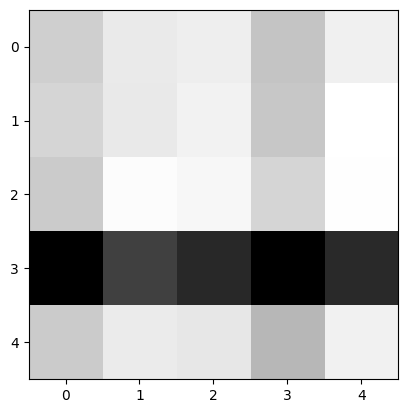

In [66]:
plt.imshow(tf.reshape(Theta_[4,:], (sqrtV, sqrtV)), cmap="Greys")

In [54]:
Theta_store = tf.stack(Theta_store, axis=-1)

In [55]:
Theta_mean = tf.reduce_mean(Theta_store, axis=-1)

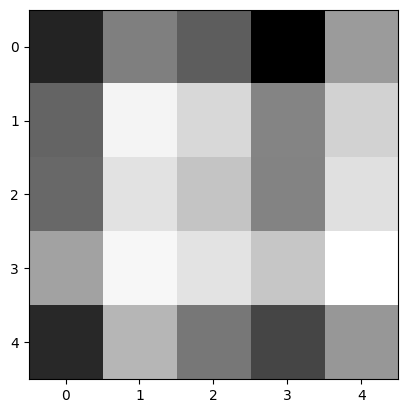

In [56]:
plt.imshow(tf.reshape(Theta_mean[3,:], (sqrtV, sqrtV)), cmap="Greys")

### TODO:

- Maybe Dropping the Padding for C is not necessairy. Maybe just collapse and expand...
- Split `tf_padd_CW` $\rightarrow$ Padding $W$ is necessairy just once.